In [1]:
import wandb
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

VAL_TOK_ACC = "eval-eval.per_token_acc"
VAL_AVG_ACC = "eval-eval.avg_acc"
TEST_TOK_ACC = "eval-test.per_token_acc"
TEST_AVG_ACC = "eval-test.avg_acc"

def get_wandb_runs(entity, project):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    return runs

def extract_run_info(run):
    run_info = {
        "run_id": run.id,
        "model": run.config.get("model"),
        "n_classes": run.config.get("data.num_classes"),
        "n_xy_train": run.config.get("data.num_xy_pairs_train")
    }
    return run_info

def get_run_history(run, keys=["eval-eval.per_token_acc", "eval-eval.avg_acc", "eval-test.per_token_acc", "eval-test.avg_acc"]):
    hist = run.history(keys=keys)
    return hist

def calculate_avg_and_extract_accs(per_token_acc):
    avg_acc = np.mean(per_token_acc)
    # pows = [int(2**i) - 1 for i in range(11)]
    # extracted_accs = per_token_acc[pows]
    extracted_accs = per_token_acc
    return avg_acc, extracted_accs

def extract_pow2_accs(x):
    pows = [int(2**i) - 1 for i in range(11)]
    extracted_accs = x[pows]
    return extracted_accs

def compute_avg_acc(x):
    return np.mean(x)

In [2]:
def build_fp(**kwargs):
    return "_".join([f"{k}={v}" for k, v in kwargs.items()]) + ".pkl"


def export_wandb_project(
    entity, project, config_cols, hist_cols, max_runs=None, states=("finished"), use_cache=False
):
    fp = build_fp(entity=entity, project=project)
    if use_cache:
        try:
            return pd.read_pickle(fp)
        except FileNotFoundError:
            print(f"Cache file not found: {fp}. Exporting from wandb.")
            pass

    runs = get_wandb_runs(entity, project)
    run_data = []

    for run in tqdm(runs, desc="Exporting run data"):
        if (max_runs is not None) and (len(run_data) >= max_runs):
            break

        if run.state not in states:
            continue

        id = {'run_id': run.id}
        config = {k: run.config.get(k) for k in config_cols}
        config.update(id)
        hist = run.history(keys=hist_cols)
        
        # Combine all information and history data
        # combined_data = pd.concat([id, config, hist], axis=1)
        combined_data = hist.assign(**config)

        # Append the combined data to run_data list
        run_data.append(combined_data)

    # Combine all run data into a single DataFrame
    all_run_data = pd.concat(run_data, ignore_index=True)

    all_run_data.to_pickle(fp)
    return all_run_data


### Start config
hist_cols = [
    "eval-eval.per_token_acc",
    "eval-eval.avg_acc",
    "eval-test.per_token_acc",
    "eval-test.avg_acc",
]
config_cols = ["model", "data.num_classes", "data.num_xy_pairs_train"]
entity = 'iceberg'
project = 'gmm-extrapolate'
max_runs = 1000
states = ("finished",)
use_cache = True
TOP_K_RUNS=3
STEP='last'
### End config

df = export_wandb_project(
    entity=entity,
    project=project,
    config_cols=config_cols,
    hist_cols=hist_cols,
    max_runs=max_runs,
    states=states,
    use_cache=use_cache,
)
print(df.shape)
df.head()


(20412, 9)


,_step,eval-eval.per_token_acc,eval-eval.avg_acc,eval-test.per_token_acc,eval-test.avg_acc,model,data.num_classes,data.num_xy_pairs_train,run_id
0,0,"[0.12400000542402267, 0.11500000208616257, 0.1...",0.125283,"[0.13100001215934753, 0.11300000548362732, 0.1...",0.124824,hyena,8,32,ivatnh6b
1,5000,"[0.10400000214576721, 0.11900000274181366, 0.1...",0.149256,"[0.1300000101327896, 0.11600000411272049, 0.11...",0.148536,hyena,8,32,ivatnh6b
2,10000,"[0.13199999928474426, 0.12800000607967377, 0.1...",0.194491,"[0.13500000536441803, 0.14300000667572021, 0.1...",0.192851,hyena,8,32,ivatnh6b
3,15000,"[0.10300000756978989, 0.1340000033378601, 0.14...",0.252293,"[0.1290000081062317, 0.15300001204013824, 0.14...",0.251775,hyena,8,32,ivatnh6b
4,20000,"[0.14000000059604645, 0.14800000190734863, 0.1...",0.206492,"[0.1120000034570694, 0.16100001335144043, 0.16...",0.206558,hyena,8,32,ivatnh6b


In [3]:
def pick_step(df, row_type):
    # group df by run_id
    grouped_df = df.groupby('run_id')
    
    if row_type == 'last':
        # only keep the last row of each group
        df = grouped_df.last()
        df = df.reset_index(drop=False)    
    elif row_type == 'best':
        # only keep the row with the highest "eval-eval.avg_acc"
        df = grouped_df.apply(lambda x: x.loc[x['eval-eval.avg_acc'].idxmax()])
    else:
        raise ValueError(f"Invalid row_type: {row_type}")

    # clean up the index
    
    return df
    
df_step = pick_step(df, row_type=STEP)
print(df_step.shape)
df_step

(972, 9)


,run_id,_step,eval-eval.per_token_acc,eval-eval.avg_acc,eval-test.per_token_acc,eval-test.avg_acc,model,data.num_classes,data.num_xy_pairs_train
0,02kouifw,100000,"[0.5230000019073486, 0.48900002241134644, 0.47...",0.500268,"[0.5139999985694885, 0.5160000324249268, 0.507...",0.500721,gru,2,32
1,035y09wd,100000,"[0.22600001096725464, 0.26100000739097595, 0.2...",0.342429,"[0.24000000953674316, 0.2900000214576721, 0.30...",0.343595,rnn,4,32
2,04bk1s79,100000,"[0.5230000019073486, 0.48900002241134644, 0.47...",0.500268,"[0.5139999985694885, 0.5160000324249268, 0.507...",0.500721,lstm,2,32
3,05k39bs8,100000,"[0.12400000542402267, 0.16600000858306885, 0.1...",0.396791,"[0.11000000685453415, 0.16300000250339508, 0.1...",0.396050,h3,8,32
4,05qvo1p4,100000,"[0.1290000081062317, 0.16600000858306885, 0.22...",0.571662,"[0.12300000339746475, 0.1680000126361847, 0.19...",0.571494,rwkv,8,32
...,...,...,...,...,...,...,...,...,...
967,zqbac71z,100000,"[0.2630000114440918, 0.3460000157356262, 0.431...",0.726449,"[0.23800000548362732, 0.3680000305175781, 0.41...",0.726805,h3,4,32
968,zsxo7rc7,100000,"[0.5040000081062317, 0.7220000624656677, 0.766...",0.206498,"[0.5170000195503235, 0.6880000233650208, 0.754...",0.207700,h3,2,32
969,zu9984lg,100000,"[0.2330000102519989, 0.2670000195503235, 0.276...",0.250548,"[0.24900001287460327, 0.25600001215934753, 0.2...",0.249851,dynamicconv,4,32
970,zxfd8ha1,100000,"[0.20900000631809235, 0.289000004529953, 0.334...",0.335869,"[0.24900001287460327, 0.29100000858306885, 0.3...",0.335468,s4,4,32


In [4]:
df_step['_step'].value_counts()

_step
100000    972
Name: count, dtype: int64

In [5]:
def top_k_rows(group, k, metric_column):
    return group.nlargest(k, metric_column)

def agg_df(df, top_k, groupby, metric_column):
    grouped = df.groupby(groupby).apply(top_k_rows, k=top_k, metric_column=metric_column).reset_index(drop=True)
    grouped = grouped.groupby(groupby).agg({VAL_TOK_ACC: list, TEST_TOK_ACC: list, '_step': list})
    grouped[VAL_TOK_ACC] = grouped[VAL_TOK_ACC].apply(lambda x: np.mean(np.array(x), axis=0))
    grouped[TEST_TOK_ACC] = grouped[TEST_TOK_ACC].apply(lambda x: np.mean(np.array(x), axis=0))
    return grouped

df_agg = agg_df(df_step, top_k=TOP_K_RUNS, groupby=['model', 'data.num_classes', 'data.num_xy_pairs_train'], metric_column='eval-eval.avg_acc')
df_agg = df_agg.reset_index()
print(df_agg.shape)
df_agg

(36, 6)


,model,data.num_classes,data.num_xy_pairs_train,eval-eval.per_token_acc,eval-test.per_token_acc,_step
0,dynamicconv,2,32,"[0.5016666849454244, 0.6846667130788168, 0.709...","[0.49800001581509906, 0.640333354473114, 0.703...","[100000, 100000, 100000]"
1,dynamicconv,4,32,"[0.2430000106493632, 0.3240000208218892, 0.355...","[0.24366668363412222, 0.33133335908253986, 0.3...","[100000, 100000, 100000]"
2,dynamicconv,8,32,"[0.12166667232910792, 0.17633333802223206, 0.1...","[0.11466667304436366, 0.18366667131582895, 0.1...","[100000, 100000, 100000]"
3,gpt2,2,32,"[0.4956666827201843, 0.7263333598772684, 0.765...","[0.5013333559036255, 0.6920000314712524, 0.747...","[100000, 100000, 100000]"
4,gpt2,4,32,"[0.2540000081062317, 0.34033334255218506, 0.42...","[0.25566668311754864, 0.3580000102519989, 0.41...","[100000, 100000, 100000]"
5,gpt2,8,32,"[0.12533333649237952, 0.17700000603993735, 0.2...","[0.1233333374063174, 0.17933333913485208, 0.19...","[100000, 100000, 100000]"
6,gru,2,32,"[0.4946666856606801, 0.71833336353302, 0.75733...","[0.498333344856898, 0.6976667046546936, 0.7410...","[100000, 100000, 100000]"
7,gru,4,32,"[0.25866668423016864, 0.32066668073336285, 0.3...","[0.25833334525426227, 0.33366668224334717, 0.3...","[100000, 100000, 100000]"
8,gru,8,32,"[0.11600000659624736, 0.13000000516573587, 0.1...","[0.13000000516573587, 0.14166667560736337, 0.1...","[100000, 100000, 100000]"
9,h3,2,32,"[0.5213333566983541, 0.7223333517710367, 0.765...","[0.5220000147819519, 0.6920000314712524, 0.748...","[100000, 100000, 100000]"


In [6]:
def post_process(df):
    df = df.copy()
    # df['per_token_acc'] = df['per_token_acc'].apply(np.array)
    df['val_tok_len'] = df[VAL_TOK_ACC].apply(len)
    df['test_tok_len'] = df[TEST_TOK_ACC].apply(len)
    
    df['val_tok_pow2'] = df[VAL_TOK_ACC].apply(extract_pow2_accs)
    df['test_tok_pow2'] = df[TEST_TOK_ACC].apply(extract_pow2_accs)

    df['val_tok_pow2_len'] = df['val_tok_pow2'].apply(len)
    df['test_tok_pow2_len'] = df['test_tok_pow2'].apply(len)
    
    df['val_avg_acc'] = df[VAL_TOK_ACC].apply(compute_avg_acc)
    df['test_avg_acc'] = df[TEST_TOK_ACC].apply(compute_avg_acc)
    
    return df
df_agg = post_process(df_agg)
df_agg.head()

,model,data.num_classes,data.num_xy_pairs_train,eval-eval.per_token_acc,eval-test.per_token_acc,_step,val_tok_len,test_tok_len,val_tok_pow2,test_tok_pow2,val_tok_pow2_len,test_tok_pow2_len,val_avg_acc,test_avg_acc
0,dynamicconv,2,32,"[0.5016666849454244, 0.6846667130788168, 0.709...","[0.49800001581509906, 0.640333354473114, 0.703...","[100000, 100000, 100000]",1024,1024,"[0.5016666849454244, 0.6846667130788168, 0.746...","[0.49800001581509906, 0.640333354473114, 0.747...",11,11,0.868639,0.866394
1,dynamicconv,4,32,"[0.2430000106493632, 0.3240000208218892, 0.355...","[0.24366668363412222, 0.33133335908253986, 0.3...","[100000, 100000, 100000]",1024,1024,"[0.2430000106493632, 0.3240000208218892, 0.380...","[0.24366668363412222, 0.33133335908253986, 0.4...",11,11,0.541874,0.543542
2,dynamicconv,8,32,"[0.12166667232910792, 0.17633333802223206, 0.1...","[0.11466667304436366, 0.18366667131582895, 0.1...","[100000, 100000, 100000]",1024,1024,"[0.12166667232910792, 0.17633333802223206, 0.1...","[0.11466667304436366, 0.18366667131582895, 0.1...",11,11,0.206579,0.206126
3,gpt2,2,32,"[0.4956666827201843, 0.7263333598772684, 0.765...","[0.5013333559036255, 0.6920000314712524, 0.747...","[100000, 100000, 100000]",1024,1024,"[0.4956666827201843, 0.7263333598772684, 0.788...","[0.5013333559036255, 0.6920000314712524, 0.796...",11,11,0.871742,0.869923
4,gpt2,4,32,"[0.2540000081062317, 0.34033334255218506, 0.42...","[0.25566668311754864, 0.3580000102519989, 0.41...","[100000, 100000, 100000]",1024,1024,"[0.2540000081062317, 0.34033334255218506, 0.49...","[0.25566668311754864, 0.3580000102519989, 0.48...",11,11,0.612412,0.610518


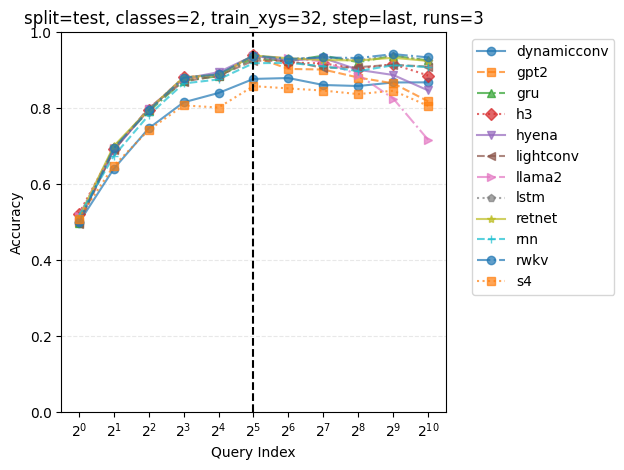

In [7]:
def plot(df, n_classes=2, val_test='val'):
    fig, ax = plt.subplots()

    if val_test == 'val':
        col_to_plot = 'val_tok_pow2'
    elif val_test == 'test':
        col_to_plot = 'test_tok_pow2'
    else:
        raise ValueError(f"Invalid val_test: {val_test}")

    # filter df to only include n_classes
    df = df[df['data.num_classes'] == n_classes]

    # Define a list of line styles, colors, and markers to cycle through
    line_styles = ["-", "--", "-.", ":"]
    colors = plt.cm.tab10(np.linspace(0, 1, 10))  # 10 distinct colors, can adjust as needed
    markers = ["o", "s", "^", "D", "v", "<", ">", "p", "*", "+"]

    # Use itertools.cycle to create an infinite loop over styles, colors, and markers
    line_styles_cycle = itertools.cycle(line_styles)
    colors_cycle = itertools.cycle(colors)
    markers_cycle = itertools.cycle(markers)

    for idx, row in df.iterrows():
        ax.plot(
            row[col_to_plot],
            label=f"{row['model']}",
            linestyle=next(line_styles_cycle),
            color=next(colors_cycle),
            marker=next(markers_cycle),
            alpha=0.7,
        )

    # draw a dotted vertical line at n_xy_train
    v_idx = int(np.log2(row["data.num_xy_pairs_train"]))
    ax.axvline(x=v_idx, linestyle="--", color="black")

    # Add faint horizontal grid lines
    ax.yaxis.grid(True, linestyle="--", which="major", color="lightgrey", alpha=0.5)

    # Set x axis to powers of 2^0 ... 2^10
    ax.set_xticks(range(0, 11))
    ax.set_xticklabels([f"$2^{{{i}}}$" for i in range(11)])

    # set y min max to 0 and 1
    ax.set_ylim([0, 1])

    # set title and labels
    ax.set_title(f"split={val_test}, classes={n_classes}, train_xys={row['data.num_xy_pairs_train']}, step={STEP}, runs={TOP_K_RUNS}")
    ax.set_xlabel("Query Index")
    ax.set_ylabel("Accuracy")
    # put legend outside of plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    # ax.legend()
    plt.tight_layout()
    plt.show()

plot(df_agg, n_classes=2, val_test='test')

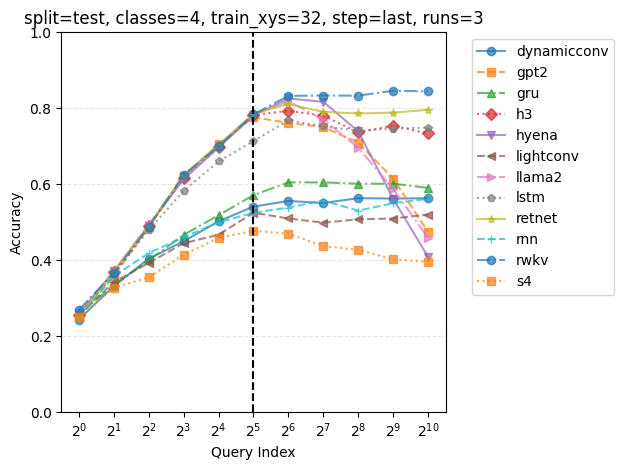

In [8]:
plot(df_agg, n_classes=4, val_test='test')

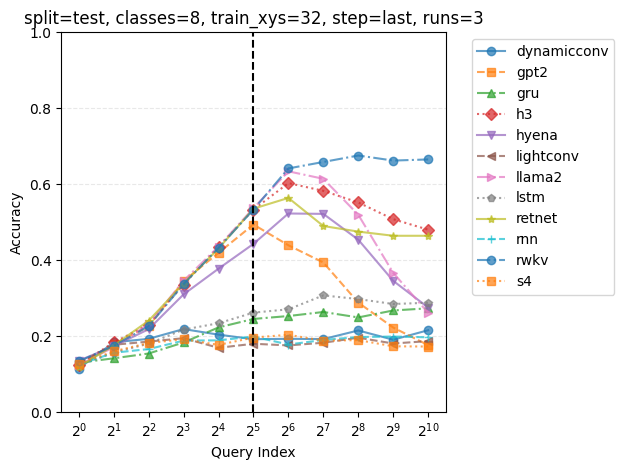

In [9]:
plot(df_agg, n_classes=8, val_test='test')

In [10]:
# compute monotonicity for each curve
def compute_monotonicity(x, eps, start_idx=0, max_idx=12):
    x = x[start_idx:max_idx]
    return np.sum((np.diff(x) + eps) > 0) / (len(x) - 1)

eps = 0.0001

df_agg['val_mono'] = df_agg['val_tok_pow2'].apply(compute_monotonicity, eps=eps)
df_agg['test_mono'] = df_agg['test_tok_pow2'].apply(compute_monotonicity, eps=eps)
df_agg['val_mono_no_extrap'] = df_agg['val_tok_pow2'].apply(compute_monotonicity, eps=eps, max_idx=6)
df_agg['test_mono_no_extrap'] = df_agg['test_tok_pow2'].apply(compute_monotonicity, eps=eps, max_idx=6)
df_agg['val_mono_extrap'] = df_agg['val_tok_pow2'].apply(compute_monotonicity, eps=eps, start_idx=6)
df_agg['test_mono_extrap'] = df_agg['test_tok_pow2'].apply(compute_monotonicity, eps=eps, start_idx=6)

def compute_avg_acc(x, start_idx=0, max_idx=12):
    x = x[start_idx:max_idx]
    return np.mean(x)

# compute avg accuracies before and after extrapolation phase
df_agg['test_acc'] = df_agg['test_tok_pow2'].apply(compute_avg_acc)
df_agg['test_acc_no_extrap'] = df_agg['test_tok_pow2'].apply(compute_avg_acc, max_idx=6)
df_agg['test_acc_extrap'] = df_agg['test_tok_pow2'].apply(compute_avg_acc, start_idx=6)


df_agg[['model', 'data.num_classes','test_avg_acc', 'test_mono', 'test_mono_no_extrap', 'test_mono_extrap', 'test_acc', 'test_acc_no_extrap', 'test_acc_extrap']]

,model,data.num_classes,test_avg_acc,test_mono,test_mono_no_extrap,test_mono_extrap,test_acc,test_acc_no_extrap,test_acc_extrap
0,dynamicconv,2,0.866394,0.8,1.0,0.50,0.795879,0.736444,0.867200
1,dynamicconv,4,0.543542,0.8,1.0,0.50,0.478879,0.412000,0.559133
2,dynamicconv,8,0.206126,0.6,0.6,0.50,0.192061,0.184333,0.201333
3,gpt2,2,0.869923,0.5,1.0,0.00,0.823758,0.781778,0.874133
4,gpt2,4,0.610518,0.5,1.0,0.00,0.592152,0.533944,0.662000
5,gpt2,8,0.252553,0.5,1.0,0.00,0.300697,0.297833,0.304133
6,gru,2,0.929788,0.7,1.0,0.50,0.847758,0.779500,0.929667
7,gru,4,0.593053,0.8,1.0,0.50,0.504606,0.424611,0.600600
8,gru,8,0.261115,0.9,1.0,0.75,0.216788,0.179611,0.261400
9,h3,2,0.905963,0.6,1.0,0.25,0.842212,0.786444,0.909133


Observation: recurrent + rwkv are the most monotonic, followed by convolutions, then the remaining att alts and transformers

In [11]:
# group df_agg by num_classes with a final group thats the average of all groups
df_agg_grouped = df_agg.groupby(["model"])
# average by test_monotonicity
df_agg_grouped = df_agg_grouped.agg(
    {
        "test_mono": ["mean", "std"],
        "test_mono_no_extrap": ["mean", "std"],
        "test_mono_extrap": ["mean", "std"],
        "test_acc": ["mean", "std"],
        "test_acc_no_extrap": ["mean", "std"],
        "test_acc_extrap": ["mean", "std"],
    }
)
df_agg_grouped = df_agg_grouped.reset_index()
df_agg_grouped.sort_values(by=[("test_mono", "mean")], ascending=False)

model test_mono           test_mono_no_extrap           \
                     mean       std                mean      std   
7          lstm  0.800000  0.000000            1.000000  0.00000   
2           gru  0.800000  0.100000            1.000000  0.00000   
9           rnn  0.800000  0.100000            1.000000  0.00000   
10         rwkv  0.800000  0.100000            1.000000  0.00000   
0   dynamicconv  0.733333  0.115470            0.866667  0.23094   
5     lightconv  0.733333  0.057735            0.933333  0.11547   
8        retnet  0.700000  0.100000            1.000000  0.00000   
3            h3  0.633333  0.057735            1.000000  0.00000   
4         hyena  0.600000  0.000000            1.000000  0.00000   
6        llama2  0.566667  0.057735            1.000000  0.00000   
11           s4  0.533333  0.057735            0.866667  0.11547   
1          gpt2  0.500000  0.000000            1.000000  0.00000   

   test_mono_extrap            test_acc           test_acc_no_extrap  \
               mean       std      mean       std               mean   
7          0.500000  0.000000  0.568828  0.308447           0.495019   
2          0.583333  0.144338  0.523051  0.315889           0.461241   
9          0.583333  0.288675  0.497394  0.327596           0.453556   
10         0.583333  0.144338  0.664556  0.192450           0.542426   
0          0.500000  0.000000  0.488939  0.302035           0.444259   
5          0.666667  0.144338  0.489747  0.332168           0.451611   
8          0.333333  0.144338  0.631919  0.230824           0.543370   
3          0.166667  0.144338  0.631646  0.213466           0.543000   
4          0.083333  0.144338  0.591929  0.246155           0.531574   
6          0.000000  0.000000  0.599960  0.216406           0.543630   
11         0.166667  0.144338  0.452495  0.303108           0.426889   
1          0.000000  0.000000  0.572202  0.262100           0.537852   

             test_acc_extrap            
         std            mean       std  
7   0.292804        0.657400  0.330885  
2   0.301617        0.597222  0.334146  
9   0.302220        0.550000  0.358873  
10  0.238417        0.811111  0.138876  
0   0.277466        0.542556  0.333243  
5   0.305286        0.535511  0.364905  
8   0.239724        0.738178  0.223807  
3   0.239703        0.738022  0.182936  
4   0.253436        0.664356  0.237423  
6   0.239256        0.667556  0.189003  
11  0.280819        0.483222  0.329858  
1   0.241996        0.613422  0.288088

In [12]:
df_agg_grouped.sort_values(by=[("test_acc", "mean")], ascending=False)

model test_mono           test_mono_no_extrap           \
                     mean       std                mean      std   
10         rwkv  0.800000  0.100000            1.000000  0.00000   
8        retnet  0.700000  0.100000            1.000000  0.00000   
3            h3  0.633333  0.057735            1.000000  0.00000   
6        llama2  0.566667  0.057735            1.000000  0.00000   
4         hyena  0.600000  0.000000            1.000000  0.00000   
1          gpt2  0.500000  0.000000            1.000000  0.00000   
7          lstm  0.800000  0.000000            1.000000  0.00000   
2           gru  0.800000  0.100000            1.000000  0.00000   
9           rnn  0.800000  0.100000            1.000000  0.00000   
5     lightconv  0.733333  0.057735            0.933333  0.11547   
0   dynamicconv  0.733333  0.115470            0.866667  0.23094   
11           s4  0.533333  0.057735            0.866667  0.11547   

   test_mono_extrap            test_acc           test_acc_no_extrap  \
               mean       std      mean       std               mean   
10         0.583333  0.144338  0.664556  0.192450           0.542426   
8          0.333333  0.144338  0.631919  0.230824           0.543370   
3          0.166667  0.144338  0.631646  0.213466           0.543000   
6          0.000000  0.000000  0.599960  0.216406           0.543630   
4          0.083333  0.144338  0.591929  0.246155           0.531574   
1          0.000000  0.000000  0.572202  0.262100           0.537852   
7          0.500000  0.000000  0.568828  0.308447           0.495019   
2          0.583333  0.144338  0.523051  0.315889           0.461241   
9          0.583333  0.288675  0.497394  0.327596           0.453556   
5          0.666667  0.144338  0.489747  0.332168           0.451611   
0          0.500000  0.000000  0.488939  0.302035           0.444259   
11         0.166667  0.144338  0.452495  0.303108           0.426889   

             test_acc_extrap            
         std            mean       std  
10  0.238417        0.811111  0.138876  
8   0.239724        0.738178  0.223807  
3   0.239703        0.738022  0.182936  
6   0.239256        0.667556  0.189003  
4   0.253436        0.664356  0.237423  
1   0.241996        0.613422  0.288088  
7   0.292804        0.657400  0.330885  
2   0.301617        0.597222  0.334146  
9   0.302220        0.550000  0.358873  
5   0.305286        0.535511  0.364905  
0   0.277466        0.542556  0.333243  
11  0.280819        0.483222  0.329858

In [13]:
# Define a list of line styles, colors, and markers to cycle through
line_styles = ["-", "--", "-.", ":"]
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # 10 distinct colors, can adjust as needed
markers = ["o", "s", "^", "D", "v", "<", ">", "p", "*", "+"]

# Use itertools.cycle to create an infinite loop over styles, colors, and markers
line_styles_cycle = itertools.cycle(line_styles)
colors_cycle = itertools.cycle(colors)
markers_cycle = itertools.cycle(markers)

# Mapping for n_classes to evenly spaced x-coordinates
mapping = {2: 1, 4: 2, 8: 3}
df_agg['x_coords'] = df_agg['data.num_classes'].map(mapping)

plt.figure(figsize=(10, 6))

offset_amount = 0.002

# Group by model and plot each group
for i, (model, group) in enumerate(df_agg.groupby('model')):
    offset_x = group['x_coords'] + i * offset_amount
    # offset_y = group['test_monotonicity'] + i * offset_amount
    plt.plot(
        offset_x,
        # group['x_coords'],
        # offset_y,
        group['test_monotonicity'],
        label=model,
        linestyle=next(line_styles_cycle),
        color=next(colors_cycle),
        marker=next(markers_cycle),
        alpha=0.6
    )

plt.title('Test Monotonicity of Models Across Different Numbers of Classes')
plt.xlabel('Number of Classes')
plt.ylabel('Test Monotonicity')
plt.xticks(list(mapping.values()), list(mapping.keys()))  # Set x-ticks to reflect original values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()

KeyError: 'test_monotonicity'

<Figure size 1000x600 with 0 Axes>

In [ ]:
succ_thresh = {2: 0.8, 4: 0.7, 8: 0.6}
idx_of_int = [3, 5, 7]
idx_of_int = [int(2**i-1) for i in idx_of_int]
idx_of_int

[7, 31, 127]

In [ ]:
def compute_success(row, succ_thresh, idx_of_int):
    thresh = succ_thresh[row['n_classes']]
    # get the accuracy at the index of interest
    acc = row['per_token_acc'][idx_of_int]
    # row['acc_of_int'] = acc
    row['success'] = acc >= thresh
    return row

succ_runs = best_runs.apply(lambda x: compute_success(x, succ_thresh, idx_of_int), axis=1)
succ_runs.success

NameError: name 'best_runs' is not defined

In [ ]:
def check_monotonicity(row, idx_of_int, epsilon=1e-5):
    acc = row['per_token_acc'][idx_of_int]
    # check if acc is monotonic
    is_monotonic = np.all(np.diff(acc) >= -epsilon)
    row['monotonic'] = is_monotonic
    return row

mono_runs = succ_runs.apply(lambda x: check_monotonicity(x, idx_of_int), axis=1)
mono_runs.monotonic

model        n_classes     
dynamicconv  2          447     True
             4          77      True
gpt2         2          261    False
gru          2          503     True
             4          136     True
h3           2          392     True
             4          42     False
hyena        2          330     True
             4          8       True
lightconv    2          487     True
             4          116    False
llama2       2          248     True
lstm         2          530     True
             4          169     True
retnet       2          316     True
             4          6      False
rnn          2          575     True
             4          195     True
rwkv         2          581     True
             4          320     True
             8          147     True
s4           2          427     True
             4          70      True
Name: monotonic, dtype: bool